# Day 4: Black-Litterman Model
## Week 5: Portfolio Optimization

---

**Learning Objectives:**
- Understand market equilibrium returns
- Incorporate views into optimization
- Implement the Black-Litterman model
- Compare to traditional MVO

In [1]:
# Day 4 Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
np.random.seed(42)

TRADING_DAYS = 252
RF_RATE = 0.05

# Load data
df = pd.read_csv('../datasets/raw_data/combined_adjusted_close.csv', 
                 index_col='Date', parse_dates=True)

assets = ['AAPL', 'MSFT', 'JPM', 'XOM', 'GLD', 'TLT']
prices = df[assets].dropna()
returns = prices.pct_change().dropna()

print("=" * 60)
print("BLACK-LITTERMAN MODEL - DAY 4")
print("=" * 60)

BLACK-LITTERMAN MODEL - DAY 4


## 1. The Black-Litterman Intuition

**Problem with MVO**: Requires expected return estimates that are notoriously unreliable.

**Black-Litterman Solution**:
1. Start with market equilibrium returns (implied by market cap weights)
2. Blend in your views with confidence levels
3. Get more stable, intuitive portfolios

In [2]:
# Market cap weights (simplified)
print("=" * 60)
print("MARKET EQUILIBRIUM RETURNS")
print("=" * 60)

# Approximate market caps ($B)
market_caps = {
    'AAPL': 3000,
    'MSFT': 2800,
    'JPM': 500,
    'XOM': 450,
    'GLD': 60,
    'TLT': 20
}

# Market cap weights
total_cap = sum(market_caps.values())
market_weights = np.array([market_caps[a] / total_cap for a in assets])

print("\n📊 Market Cap Weights:")
for asset, weight in zip(assets, market_weights):
    print(f"  {asset}: {weight:.2%}")

# Covariance matrix
cov_matrix = returns.cov() * TRADING_DAYS

# Risk aversion parameter (typically 2-4)
risk_aversion = 2.5

# Implied equilibrium returns: π = δΣw_mkt
equilibrium_returns = risk_aversion * cov_matrix.dot(market_weights)

print("\n📊 Implied Equilibrium Returns (Annualized):")
for asset, ret in zip(assets, equilibrium_returns):
    print(f"  {asset}: {ret:.2%}")

# Compare to historical returns
historical_returns = returns.mean() * TRADING_DAYS

comparison = pd.DataFrame({
    'Asset': assets,
    'Historical': historical_returns.values,
    'Equilibrium': equilibrium_returns
})
print("\n📊 Comparison:")
print(comparison.round(4).to_string(index=False))

MARKET EQUILIBRIUM RETURNS

📊 Market Cap Weights:
  AAPL: 43.92%
  MSFT: 41.00%
  JPM: 7.32%
  XOM: 6.59%
  GLD: 0.88%
  TLT: 0.29%

📊 Implied Equilibrium Returns (Annualized):
  AAPL: 18.04%
  MSFT: 15.98%
  JPM: 10.45%
  XOM: 7.86%
  GLD: 0.79%
  TLT: -1.39%

📊 Comparison:
Asset  Historical  Equilibrium
 AAPL      0.3212       0.1804
 MSFT      0.2653       0.1598
  JPM      0.2364       0.1045
  XOM      0.1836       0.0786
  GLD      0.1897       0.0079
  TLT     -0.0058      -0.0139


## 2. Expressing Views

In [3]:
# Express views
print("=" * 60)
print("EXPRESSING VIEWS")
print("=" * 60)

# Views are expressed as:
# P @ returns = Q + epsilon, where epsilon ~ N(0, Omega)

# View 1: AAPL will outperform MSFT by 3%
# View 2: JPM will return 10%
# View 3: GLD will outperform TLT by 2%

n_assets = len(assets)
n_views = 3

# P matrix: each row represents a view
# Columns correspond to assets in order
P = np.zeros((n_views, n_assets))

# View 1: AAPL - MSFT = 3%
P[0, assets.index('AAPL')] = 1
P[0, assets.index('MSFT')] = -1

# View 2: JPM = 10%
P[1, assets.index('JPM')] = 1

# View 3: GLD - TLT = 2%
P[2, assets.index('GLD')] = 1
P[2, assets.index('TLT')] = -1

# Q vector: view magnitudes
Q = np.array([0.03, 0.10, 0.02])

# View confidence (uncertainty)
view_confidence = np.array([0.5, 0.3, 0.7])  # 0 = no confidence, 1 = full confidence

print("\n📊 Views:")
print("  View 1: AAPL outperforms MSFT by 3% (confidence: 50%)")
print("  View 2: JPM returns 10% (confidence: 30%)")
print("  View 3: GLD outperforms TLT by 2% (confidence: 70%)")

print("\nP matrix:")
print(pd.DataFrame(P, columns=assets, index=['View 1', 'View 2', 'View 3']))

EXPRESSING VIEWS

📊 Views:
  View 1: AAPL outperforms MSFT by 3% (confidence: 50%)
  View 2: JPM returns 10% (confidence: 30%)
  View 3: GLD outperforms TLT by 2% (confidence: 70%)

P matrix:
        AAPL  MSFT  JPM  XOM  GLD  TLT
View 1   1.0  -1.0  0.0  0.0  0.0  0.0
View 2   0.0   0.0  1.0  0.0  0.0  0.0
View 3   0.0   0.0  0.0  0.0  1.0 -1.0


## 3. Black-Litterman Formula

In [4]:
# Black-Litterman implementation
print("=" * 60)
print("BLACK-LITTERMAN MODEL")
print("=" * 60)

def black_litterman(equilibrium_returns, cov_matrix, P, Q, view_confidence, tau=0.05):
    """
    Black-Litterman model implementation.
    
    Parameters:
    - equilibrium_returns: π (implied equilibrium returns)
    - cov_matrix: Σ (covariance matrix)
    - P: View matrix (K x N)
    - Q: View returns (K x 1)
    - view_confidence: Confidence in views (used to build Ω)
    - tau: Scaling factor for uncertainty in equilibrium
    
    Returns:
    - BL expected returns
    - BL covariance matrix
    """
    n_views = len(Q)
    
    # Omega: uncertainty in views (diagonal matrix)
    # Lower confidence = higher variance
    Omega = np.diag([(1 - c) * 0.1 for c in view_confidence])
    
    # Tau*Sigma: uncertainty in equilibrium
    tau_sigma = tau * cov_matrix
    
    # Black-Litterman formula
    # μ_BL = [(τΣ)^-1 + P'Ω^-1 P]^-1 [(τΣ)^-1 π + P'Ω^-1 Q]
    
    tau_sigma_inv = np.linalg.inv(tau_sigma)
    Omega_inv = np.linalg.inv(Omega)
    
    # Precision matrix
    precision = tau_sigma_inv + P.T @ Omega_inv @ P
    precision_inv = np.linalg.inv(precision)
    
    # BL expected returns
    bl_returns = precision_inv @ (tau_sigma_inv @ equilibrium_returns + P.T @ Omega_inv @ Q)
    
    # BL covariance (optional, for confidence intervals)
    bl_cov = precision_inv + cov_matrix
    
    return bl_returns, bl_cov

# Calculate BL returns
bl_returns, bl_cov = black_litterman(
    equilibrium_returns.values, 
    cov_matrix.values, 
    P, Q, 
    view_confidence
)

print("\n📊 Black-Litterman Expected Returns:")
results = pd.DataFrame({
    'Asset': assets,
    'Historical': historical_returns.values,
    'Equilibrium': equilibrium_returns,
    'Black-Litterman': bl_returns
})
print(results.round(4).to_string(index=False))

BLACK-LITTERMAN MODEL

📊 Black-Litterman Expected Returns:
Asset  Historical  Equilibrium  Black-Litterman
 AAPL      0.3212       0.1804           0.1806
 MSFT      0.2653       0.1598           0.1595
  JPM      0.2364       0.1045           0.1042
  XOM      0.1836       0.0786           0.0785
  GLD      0.1897       0.0079           0.0079
  TLT     -0.0058      -0.0139          -0.0138


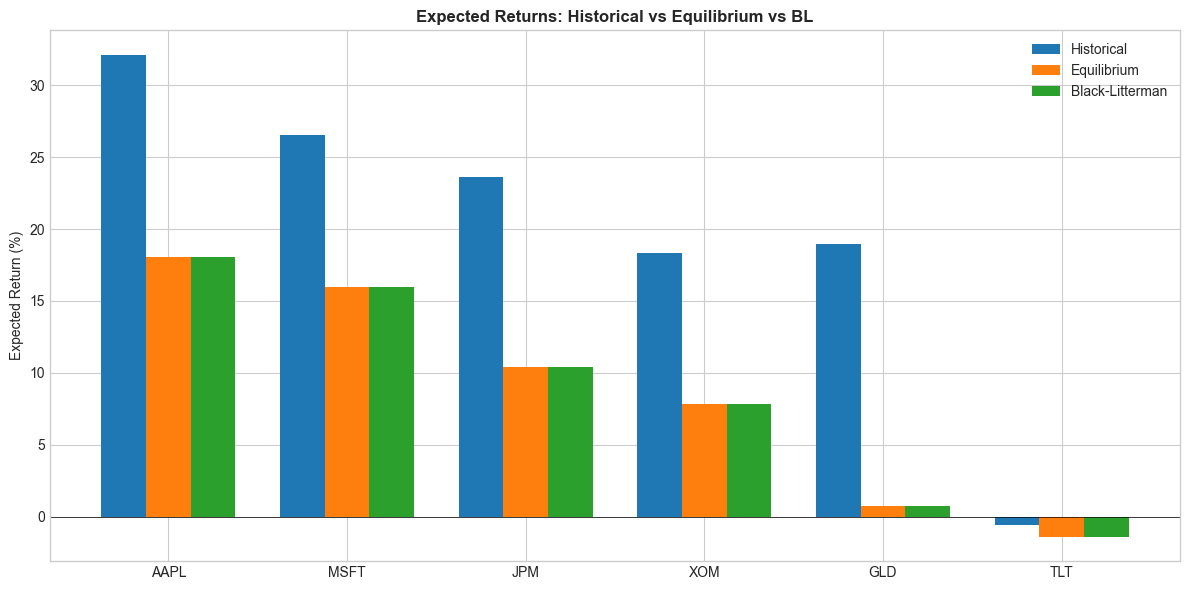

In [5]:
# Visualize return differences
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(assets))
width = 0.25

ax.bar(x - width, historical_returns.values * 100, width, label='Historical')
ax.bar(x, equilibrium_returns * 100, width, label='Equilibrium')
ax.bar(x + width, bl_returns * 100, width, label='Black-Litterman')

ax.set_xticks(x)
ax.set_xticklabels(assets)
ax.set_ylabel('Expected Return (%)')
ax.set_title('Expected Returns: Historical vs Equilibrium vs BL', fontweight='bold')
ax.legend()
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

plt.tight_layout()
plt.show()

## 4. Optimal Portfolios Comparison

In [6]:
# Compare optimal portfolios
print("=" * 60)
print("OPTIMAL PORTFOLIO COMPARISON")
print("=" * 60)

def max_sharpe_portfolio(expected_returns, cov_matrix, rf_rate=RF_RATE):
    """Find max Sharpe portfolio."""
    n = len(expected_returns)
    
    def neg_sharpe(w):
        ret = np.dot(w, expected_returns)
        vol = np.sqrt(np.dot(w.T, np.dot(cov_matrix, w)))
        return -(ret - rf_rate) / vol
    
    constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
    bounds = tuple((0, 1) for _ in range(n))
    
    result = minimize(neg_sharpe, np.array([1/n]*n), method='SLSQP',
                     bounds=bounds, constraints=constraints)
    return result.x

# Different return estimates
portfolios = {}

# Historical returns
portfolios['Historical'] = max_sharpe_portfolio(historical_returns.values, cov_matrix.values)

# Equilibrium returns
portfolios['Equilibrium'] = max_sharpe_portfolio(equilibrium_returns, cov_matrix.values)

# Black-Litterman returns
portfolios['Black-Litterman'] = max_sharpe_portfolio(bl_returns, cov_matrix.values)

# Market weights
portfolios['Market'] = market_weights

# Compare weights
weights_df = pd.DataFrame(portfolios, index=assets)
print("\n📊 Optimal Weights:")
print(weights_df.round(4))

# Compare performance
print("\n📊 Portfolio Metrics:")
for name, weights in portfolios.items():
    ret = np.dot(weights, bl_returns)  # Use BL returns for fair comparison
    vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix.values, weights)))
    sharpe = (ret - RF_RATE) / vol
    print(f"  {name}: Return={ret:.2%}, Vol={vol:.2%}, Sharpe={sharpe:.3f}")

OPTIMAL PORTFOLIO COMPARISON

📊 Optimal Weights:
      Historical  Equilibrium  Black-Litterman  Market
AAPL      0.2004        0.593           0.5987  0.4392
MSFT      0.0659        0.407           0.4013  0.4100
JPM       0.1304        0.000           0.0000  0.0732
XOM       0.0000        0.000           0.0000  0.0659
GLD       0.6033        0.000           0.0000  0.0088
TLT       0.0000        0.000           0.0000  0.0029

📊 Portfolio Metrics:
  Historical: Return=6.50%, Vol=14.12%, Sharpe=0.107
  Equilibrium: Return=17.20%, Vol=27.70%, Sharpe=0.440
  Black-Litterman: Return=17.21%, Vol=27.73%, Sharpe=0.440
  Market: Return=15.75%, Vol=25.11%, Sharpe=0.428


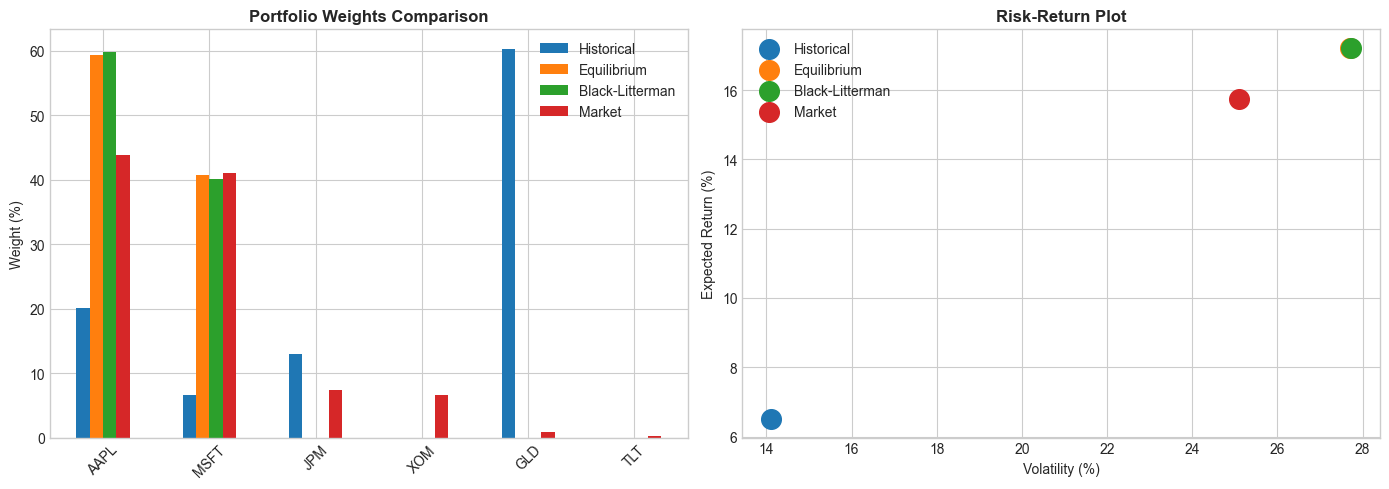

In [7]:
# Visualize portfolios
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Weight comparison
weights_df_plot = weights_df * 100
weights_df_plot.plot(kind='bar', ax=axes[0])
axes[0].set_ylabel('Weight (%)')
axes[0].set_title('Portfolio Weights Comparison', fontweight='bold')
axes[0].tick_params(axis='x', rotation=45)
axes[0].legend(loc='upper right')

# Risk-return scatter
for name, weights in portfolios.items():
    ret = np.dot(weights, bl_returns)
    vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix.values, weights)))
    axes[1].scatter(vol * 100, ret * 100, s=200, label=name)

axes[1].set_xlabel('Volatility (%)')
axes[1].set_ylabel('Expected Return (%)')
axes[1].set_title('Risk-Return Plot', fontweight='bold')
axes[1].legend()

plt.tight_layout()
plt.show()

## 5. Sensitivity Analysis

SENSITIVITY ANALYSIS

📊 Impact of View 1 Confidence:
 Confidence  AAPL Weight  MSFT Weight  AAPL Return  MSFT Return
        0.1       0.5963       0.4037       0.1804       0.1596
        0.3       0.5972       0.4028       0.1805       0.1596
        0.5       0.5987       0.4013       0.1806       0.1595
        0.7       0.6022       0.3978       0.1808       0.1594
        0.9       0.6163       0.3837       0.1816       0.1590


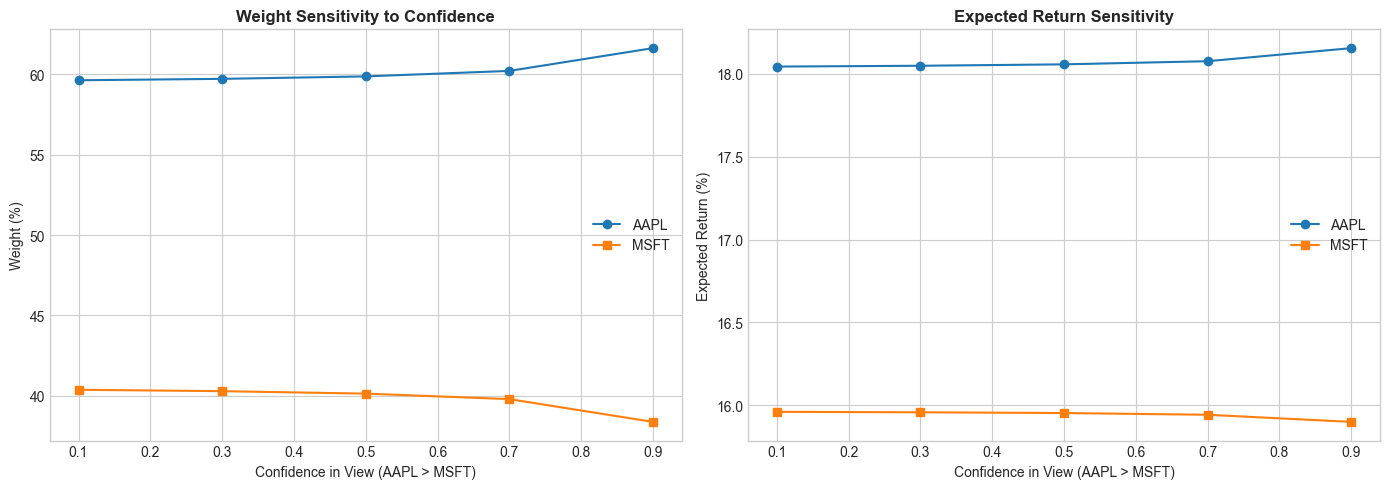

In [8]:
# Sensitivity to view confidence
print("=" * 60)
print("SENSITIVITY ANALYSIS")
print("=" * 60)

# Vary confidence in View 1 (AAPL > MSFT)
confidence_levels = np.linspace(0.1, 0.9, 5)

sensitivity_results = []
for conf in confidence_levels:
    test_confidence = view_confidence.copy()
    test_confidence[0] = conf
    
    bl_ret, _ = black_litterman(
        equilibrium_returns.values, 
        cov_matrix.values, 
        P, Q, 
        test_confidence
    )
    
    optimal_w = max_sharpe_portfolio(bl_ret, cov_matrix.values)
    
    sensitivity_results.append({
        'Confidence': conf,
        'AAPL Weight': optimal_w[0],
        'MSFT Weight': optimal_w[1],
        'AAPL Return': bl_ret[0],
        'MSFT Return': bl_ret[1]
    })

sens_df = pd.DataFrame(sensitivity_results)
print("\n📊 Impact of View 1 Confidence:")
print(sens_df.round(4).to_string(index=False))

# Plot sensitivity
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(sens_df['Confidence'], sens_df['AAPL Weight'] * 100, 'o-', label='AAPL')
axes[0].plot(sens_df['Confidence'], sens_df['MSFT Weight'] * 100, 's-', label='MSFT')
axes[0].set_xlabel('Confidence in View (AAPL > MSFT)')
axes[0].set_ylabel('Weight (%)')
axes[0].set_title('Weight Sensitivity to Confidence', fontweight='bold')
axes[0].legend()

axes[1].plot(sens_df['Confidence'], sens_df['AAPL Return'] * 100, 'o-', label='AAPL')
axes[1].plot(sens_df['Confidence'], sens_df['MSFT Return'] * 100, 's-', label='MSFT')
axes[1].set_xlabel('Confidence in View (AAPL > MSFT)')
axes[1].set_ylabel('Expected Return (%)')
axes[1].set_title('Expected Return Sensitivity', fontweight='bold')
axes[1].legend()

plt.tight_layout()
plt.show()

## 📝 Key Takeaways - Day 4

### Black-Litterman Advantages:
1. **Intuitive starting point**: Market equilibrium (not historical returns)
2. **Flexible views**: Express views with confidence levels
3. **More stable**: Less extreme weights than traditional MVO
4. **Combines information**: Market wisdom + your views

### Key Formula:
$$\mu_{BL} = [(\tau\Sigma)^{-1} + P'\Omega^{-1}P]^{-1}[(\tau\Sigma)^{-1}\pi + P'\Omega^{-1}Q]$$

Where:
- $\pi$: Equilibrium returns
- $P$: View matrix
- $Q$: View returns
- $\Omega$: View uncertainty
- $\tau$: Equilibrium uncertainty

### Interview Questions:
- "What problem does Black-Litterman solve?"
- "How are equilibrium returns calculated?"
- "How do you incorporate views into BL?"
- "What is tau in the BL model?"